In the following section, I performed an initial exploration of the dataset to understand its structure, size, data types, missing values, and basic patterns before moving on to cleaning and deeper analysis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('../data/netflix_titles.csv')

# Preview dataset
df.head()
 
# View random samples
df.sample(5)

# Check dataset shape
df.shape

# Check data types and non-null counts
df.info()

# Check missing values
df.isnull().sum()

# Statistical summary of numerical columns
df.describe()

# Check duplicate rows
df.duplicated().sum()

# Correlation between numerical columns
df.corr(numeric_only=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


,release_year
release_year,1.0


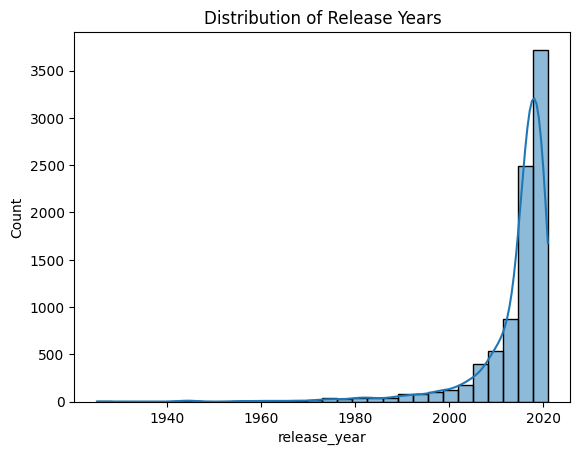

0       90 min
1    2 Seasons
2     1 Season
3     1 Season
4    2 Seasons
5     1 Season
6       91 min
7      125 min
8    9 Seasons
9      104 min
Name: duration, dtype: object

In [2]:
# ================================
# UNIVARIATE ANALYSIS
# ================================

# -------------------------------
# PART A: CATEGORICAL UNIVARIATE
# -------------------------------

# Most common ratings
df["rating"].value_counts().head(10)

# Most common genres
df["listed_in"].value_counts().head(10)

# -------------------------------
# PART B: NUMERICAL UNIVARIATE
# -------------------------------

# Release year statistics
df["release_year"].describe()

sns.histplot(df["release_year"], bins=30, kde=True)
plt.title("Distribution of Release Years")
plt.show()

# Preview duration column
df["duration"].head(10)

# -------------------------------
# Notes for later cleaning
# -------------------------------
# - duration contains text (e.g., "90 min", "2 Seasons")
# - missing values exist
# - will clean duration and split movies vs tv shows later


After initial exploration, I cleaned the dataset by handling missing values, standardizing text columns, and converting the date_added column into a proper datetime format. I also extracted year and month from the date to support time-based analysis later.

In [3]:
# ================================
# DATA CLEANING / PREPROCESSING
# ================================

# Check missing values
df.isnull().sum()

# -------------------------------
# Fill Missing Categorical Values
# -------------------------------

df["director"] = df["director"].fillna("Unknown")
df["cast"] = df["cast"].fillna("Unknown")
df["country"] = df["country"].fillna("Unknown")
df["rating"] = df["rating"].fillna("Unknown")

# -------------------------------
# Fill Other Important Columns
# -------------------------------

df["duration"] = df["duration"].fillna("0")
df["date_added"] = df["date_added"].fillna("Unknown")

# -------------------------------
# Standardize Text Columns
# -------------------------------

cat_cols = ["type", "rating", "country", "listed_in"]

for col in cat_cols:
    df[col] = df[col].str.strip()

# -------------------------------
# Convert date_added to datetime
# -------------------------------

df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")

# Extract year and month
df["year_added"] = df["date_added"].dt.year
df["month_added"] = df["date_added"].dt.month

# Preview extracted values
df[["date_added", "year_added", "month_added"]].head()


,date_added,year_added,month_added
0,2021-09-25,2021.0,9.0
1,2021-09-24,2021.0,9.0
2,2021-09-24,2021.0,9.0
3,2021-09-24,2021.0,9.0
4,2021-09-24,2021.0,9.0


Question: Which countries produce the most Netflix content, and is content production dominated by a small number of countries?

Approach: Since many titles are associated with multiple countries (for example, "United States, India"), I first split the country column and expanded it so that each country is counted separately.

In [4]:

# -------------------------------
# Country-Level Analysis (Split & Explode)
# -------------------------------

# Split country column into lists
df["country_list"] = df["country"].str.split(",")

# Expand lists into separate rows
exploded = df.explode("country_list")

# Remove leading/trailing spaces
exploded["country_list"] = exploded["country_list"].str.strip()

# Count occurrences
country_counts = exploded["country_list"].value_counts()

# Top 10 countries
top_countries = country_counts.head(10)
top_countries


country_list
United States     3690
India             1046
Unknown            831
United Kingdom     806
Canada             445
France             393
Japan              318
Spain              232
South Korea        231
Germany            226
Name: count, dtype: int64

In [ ]:
# Visualize top 10 countries
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_countries.values,
    y=top_countries.index
)
plt.title("Top 10 Countries Producing Netflix Content")
plt.xlabel("Number of Titles")
plt.ylabel("Country")
plt.show()


Insight: The United States produces the largest number of Netflix titles, followed by India and the United Kingdom. This suggests that while Netflix has a global presence, content production is still concentrated in a few major countries

Question: Which genres are most popular on Netflix?

Approach: Since multiple genres can be listed for a single title, I split the listed_in column into individual genres and expanded them into separate rows so that each genre is counted independently.

In [5]:
# -------------------------------
# Genre-Level Analysis
# -------------------------------

# Split genres into lists
df["genre_list"] = df["listed_in"].str.split(",")

# Explode into individual rows
genre_exploded = df.explode("genre_list")

# Remove leading/trailing spaces
genre_exploded["genre_list"] = genre_exploded["genre_list"].str.strip()

# Count occurrences
genre_counts = genre_exploded["genre_list"].value_counts()

# Top 10 genres
top_genres = genre_counts.head(10)
top_genres


genre_list
International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Name: count, dtype: int64

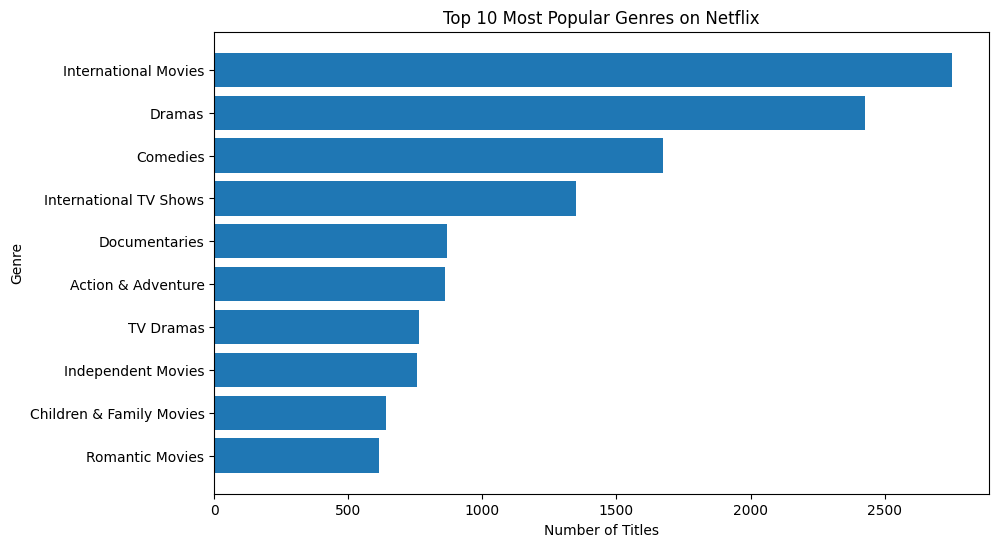

In [6]:
# Visualization
plt.figure(figsize=(10, 6))
plt.barh(top_genres.index, top_genres.values)
plt.title("Top 10 Most Popular Genres on Netflix")
plt.xlabel("Number of Titles")
plt.ylabel("Genre")
plt.gca().invert_yaxis()
plt.show()


Insight: Drama is the most common genre on Netflix, followed by Comedy and International Movies. This indicates that Netflix’s catalog is heavily focused on narrative-driven and globally appealing content.

Question: Which actors appear most frequently on Netflix?

Approach: Since multiple actors are listed for each title, I split the cast column into individual actor names and expanded them into separate rows so that each appearance is counted independently. Titles with unknown cast information were excluded.

In [7]:
# -------------------------------
# Actor-Level Analysis
# -------------------------------

# Remove rows with unknown cast
cast_df = df[df["cast"] != "Unknown"].copy()

# Split cast into lists
cast_df["cast_list"] = cast_df["cast"].str.split(",")

# Explode into individual rows
cast_exploded = cast_df.explode("cast_list")

# Remove leading/trailing spaces
cast_exploded["cast_list"] = cast_exploded["cast_list"].str.strip()

# Count occurrences
actor_counts = cast_exploded["cast_list"].value_counts()

# Top 10 actors
top_actors = actor_counts.head(10)
top_actors


cast_list
Anupam Kher         43
Shah Rukh Khan      35
Julie Tejwani       33
Naseeruddin Shah    32
Takahiro Sakurai    32
Rupa Bhimani        31
Akshay Kumar        30
Om Puri             30
Yuki Kaji           29
Paresh Rawal        28
Name: count, dtype: int64

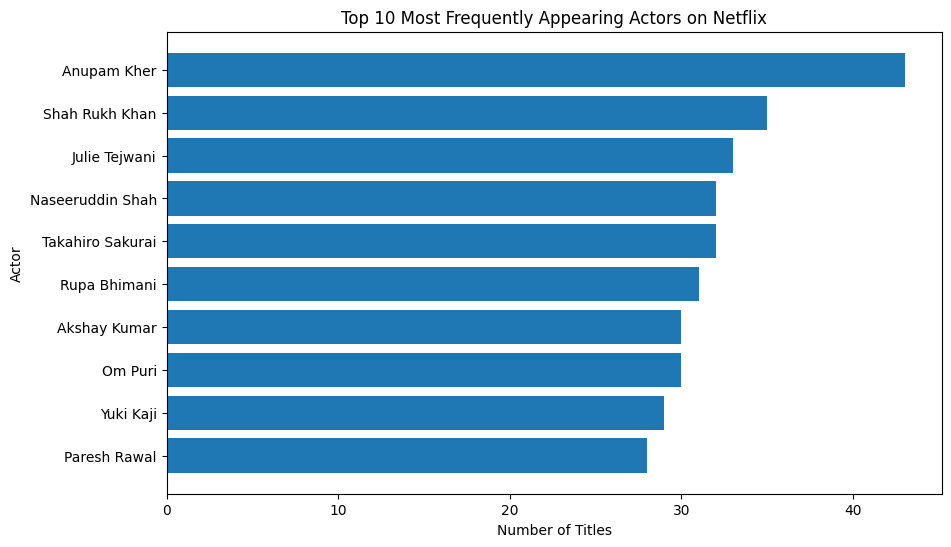

In [8]:
# Visualization
plt.figure(figsize=(10, 6))
plt.barh(top_actors.index, top_actors.values)
plt.title("Top 10 Most Frequently Appearing Actors on Netflix")
plt.xlabel("Number of Titles")
plt.ylabel("Actor")
plt.gca().invert_yaxis()
plt.show()


Insight: A small group of actors appear repeatedly across Netflix titles, indicating frequent collaborations and strong representation of certain actors within the platform’s catalog.

Question: Do certain countries produce more Movies or TV Shows?

Approach: Using the exploded country dataset, I focused on the top 10 countries by number of titles and compared how their content is split between Movies and TV Shows.

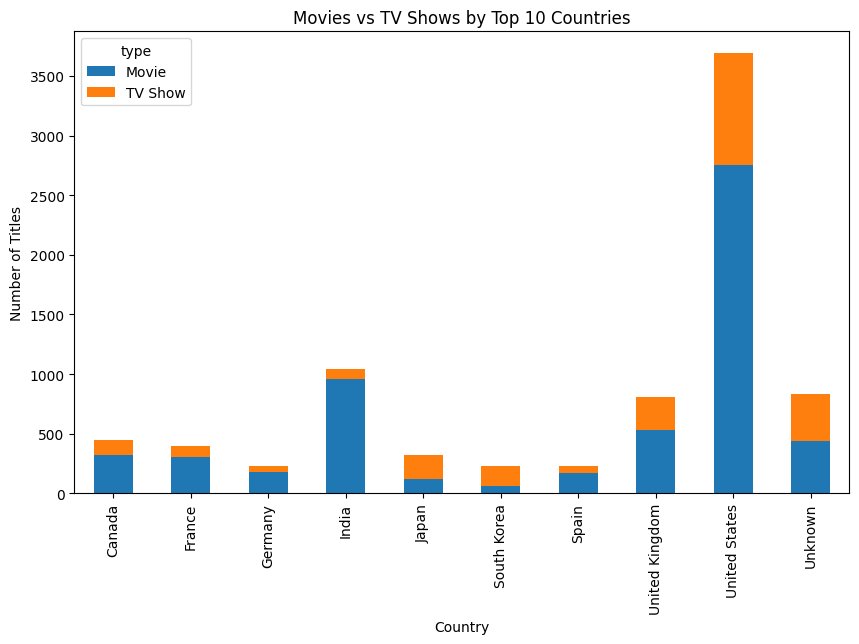

In [9]:
# -------------------------------
# BIVARIATE ANALYSIS
# Country vs Type
# -------------------------------

# Top 10 countries
top_countries = exploded["country_list"].value_counts().head(10).index

# Filter dataset
df_top_countries = exploded[exploded["country_list"].isin(top_countries)]

# Count titles by country and type
country_type_counts = (
    df_top_countries
    .groupby(["country_list", "type"])
    .size()
    .unstack()
)

# Visualization
country_type_counts.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Movies vs TV Shows by Top 10 Countries")
plt.xlabel("Country")
plt.ylabel("Number of Titles")
plt.show()


Insight: The Country × Type analysis highlights Netflix’s regional content strategy and shows how production formats vary across countries based on audience preferences and market maturity.

Question: Do Movies and TV Shows differ in maturity ratings?

Approach: I grouped titles by maturity rating and content type (Movie vs TV Show) to compare how rating distributions differ between the two formats.

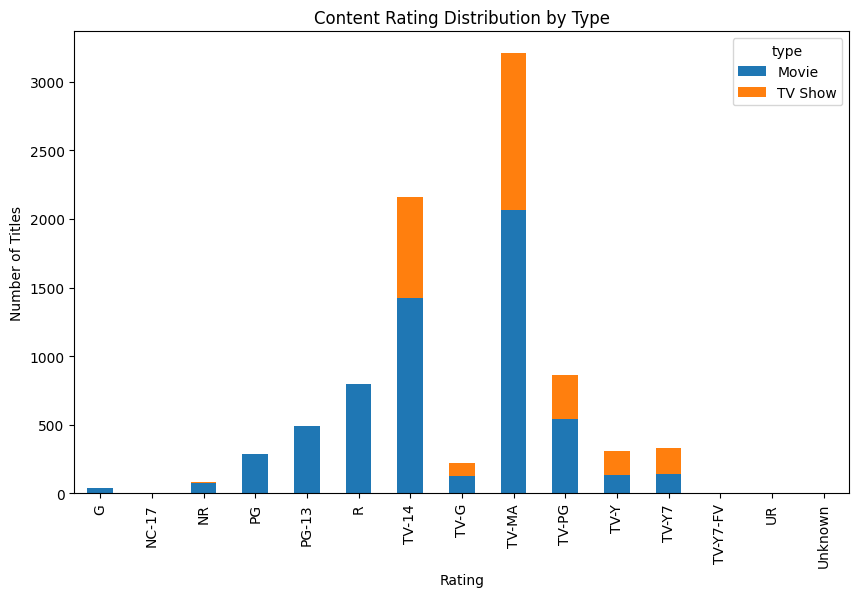

In [10]:
# -------------------------------
# BIVARIATE ANALYSIS
# Rating vs Type
# -------------------------------

# Standardize rating values
df["rating"] = df["rating"].replace("Unkown", "Unknown")

# Remove rows where rating accidentally contains duration text
df = df[~df["rating"].str.contains("min", na=False)]

# Group and count
rating_type = (
    df.groupby(["rating", "type"])
      .size()
      .unstack()
)

# Visualization
rating_type.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Content Rating Distribution by Type")
plt.xlabel("Rating")
plt.ylabel("Number of Titles")
plt.show()


Insight: Netflix’s content strategy shows a clear difference in maturity ratings by type. Movies tend to lean toward adult audiences (R, PG-13), while TV Shows more often target both teen and adult viewers (TV-14, TV-MA). This suggests Netflix uses different formats to engage different age groups

Question: Are certain genres more common in Movies or TV Shows?

Approach: Using the exploded genre dataset, I compared how frequently each genre appears within Movies and TV Shows, focusing on the top 10 most common genres overall.

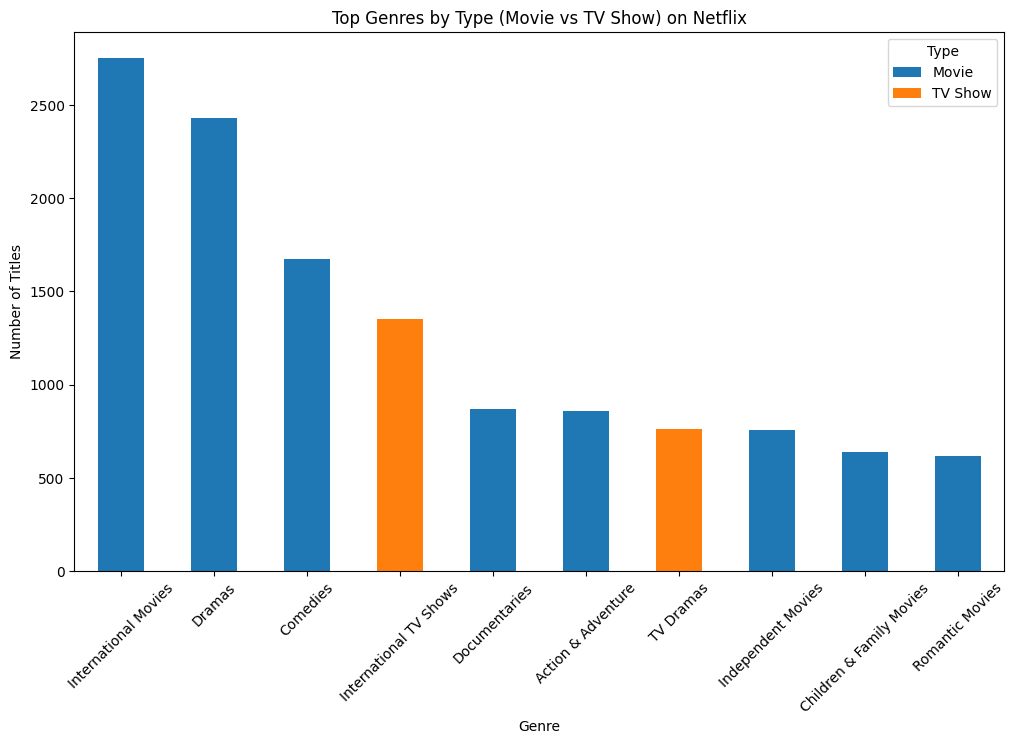

In [11]:
# -------------------------------
# BIVARIATE ANALYSIS
# Genre vs Type
# -------------------------------

# Check missing genres
df["listed_in"].isnull().sum()

# Count genres separately for Movies and TV Shows
genre_type_counts = (
    genre_exploded
    .groupby(["type", "genre_list"])
    .size()
    .unstack(fill_value=0)
)

# Top 10 genres overall
top_genres = genre_exploded["genre_list"].value_counts().head(10).index

# Filter to top genres
top_genre_type_counts = genre_type_counts[top_genres]

# Visualization
top_genre_type_counts.T.plot(kind="bar", stacked=True, figsize=(12, 7))
plt.title("Top Genres by Type (Movie vs TV Show) on Netflix")
plt.xlabel("Genre")
plt.ylabel("Number of Titles")
plt.xticks(rotation=45)
plt.legend(title="Type")
plt.show()


Insight: Drama and Comedy are dominant genres for both Movies and TV Shows. However, some genres such as Documentaries and Kids’ content appear more frequently in TV Shows, while International Movies and Action-related genres are more prominent among Movies. This highlights how Netflix tailors genre distribution based on content format.

Question: Has Netflix shifted toward TV Shows over time?

Approach: Using the year extracted from the date_added column, I grouped titles by year and content type to observe how the number of Movies and TV Shows added to Netflix has changed over time. Rows with missing year values were removed to ensure reliable trends.

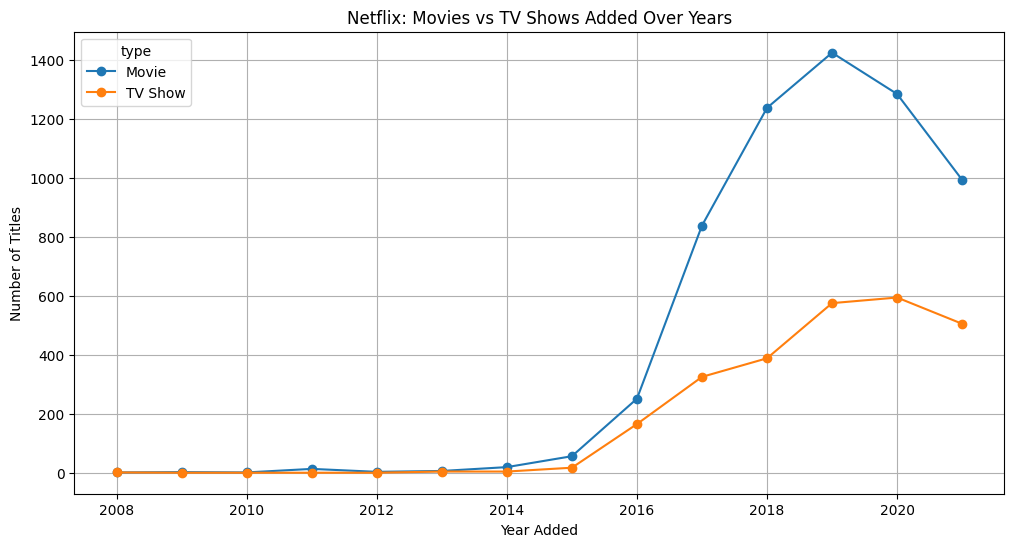

In [12]:
# -------------------------------
# BIVARIATE ANALYSIS
# Year Added vs Type
# -------------------------------

# Preview date_added values
df["date_added"].sample(10)

# Drop rows with missing year
df_year = df.dropna(subset=["year_added"])

# Count titles by year and type
year_type_counts = (
    df_year
    .groupby(["year_added", "type"])
    .size()
    .unstack()
    .fillna(0)
)

# Visualization
year_type_counts.plot(kind="line", figsize=(12, 6), marker="o")
plt.title("Netflix: Movies vs TV Shows Added Over Years")
plt.xlabel("Year Added")
plt.ylabel("Number of Titles")
plt.grid(True)
plt.show()


Insight: Over time, Netflix has increasingly added more TV Shows relative to Movies, suggesting a strategic shift toward episodic content that supports longer user engagement and retention.

Question: What is the typical duration of movies on Netflix?

Approach: I filtered the dataset to include only Movies, cleaned the duration column by removing text values such as "min", converted it to numeric format, and filled missing or zero values using the median. A boxplot was then used to examine the distribution and presence of outliers.

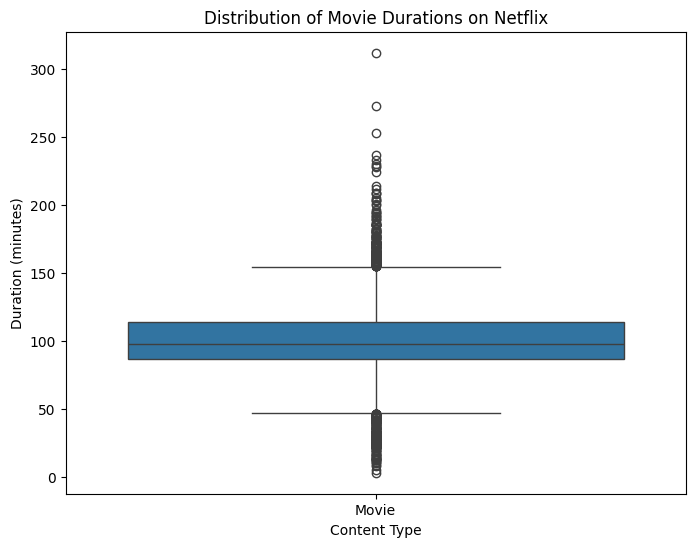

In [13]:
# -------------------------------
# BIVARIATE ANALYSIS
# Movie Duration (Minutes)
# -------------------------------

# Filter movies only
movies = df[df["type"] == "Movie"].copy()

# Clean duration column
movies["duration_min"] = (
    movies["duration"]
    .astype(str)
    .str.strip()
    .str.replace("min", "", regex=False)
    .astype(float)
)

# Fill missing and zero values with median
median_duration = movies.loc[movies["duration_min"] > 0, "duration_min"].median()
movies["duration_min"] = movies["duration_min"].fillna(median_duration)
movies["duration_min"] = movies["duration_min"].replace(0, median_duration)

# Visualization
plt.figure(figsize=(8, 6))
sns.boxplot(x="type", y="duration_min", data=movies)
plt.title("Distribution of Movie Durations on Netflix")
plt.xlabel("Content Type")
plt.ylabel("Duration (minutes)")
plt.show()


Insight: Netflix movie durations are highly concentrated around the 90–120 minute range, with a few extreme outliers. This suggests Netflix primarily targets standard feature-length films while still offering some unusually short or long content.

Question: Do certain genres tend to have longer movie runtimes on Netflix?

Approach: I filtered movie records, merged cleaned movie durations with genre data, selected the top 10 most frequent genres, and calculated summary statistics (median, mean, count) for each genre to compare typical runtimes.

In [14]:
# Filter movie genres
movie_genres = genre_exploded[genre_exploded['type'] == 'Movie'].copy()

# Merge with cleaned movie duration
movie_genres = movie_genres.merge(
    movies[['show_id', 'duration_min']],
    on='show_id',
    how='inner'
)

# Select top 10 most frequent genres
top_genres = movie_genres['genre_list'].value_counts().head(10).index
movie_genres_top = movie_genres[movie_genres['genre_list'].isin(top_genres)]

# Aggregate duration statistics
genre_duration_stats = (
    movie_genres_top
    .groupby('genre_list')['duration_min']
    .agg(['median', 'mean', 'count'])
    .sort_values(by='median', ascending=False)
)

genre_duration_stats


,median,mean,count
genre_list,,,
Dramas,109.0,113.051092,2427
Action & Adventure,108.0,113.515716,859
International Movies,107.0,110.349927,2752
Romantic Movies,107.0,110.573052,616
Thrillers,103.0,107.166378,577
Comedies,101.0,103.876344,1674
Music & Musicals,101.0,106.125333,375
Independent Movies,98.0,101.051587,756
Children & Family Movies,87.0,79.936037,641


Insight: Some genres have longer movies than others on Netflix. Dramas and Action movies are usually longer, while Children & Family and Documentary movies are shorter, showing that Netflix adjusts movie length based on genre.

### Question: Has Netflix shifted towards producing more TV Shows rather than Movies over time?


<Figure size 1000x600 with 0 Axes>

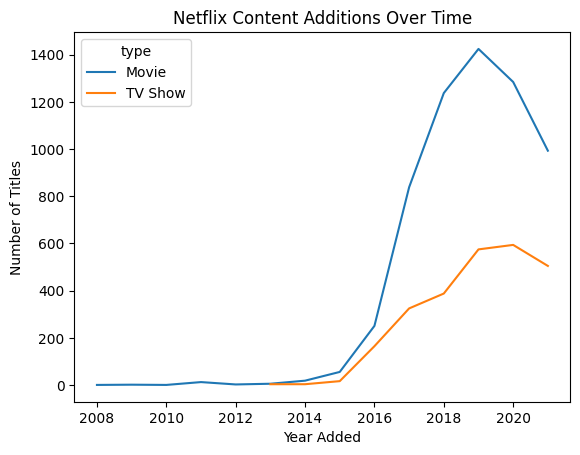

In [15]:
# Convert date_added to datetime
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")

# Extract year from date_added
df["year_added"] = df["date_added"].dt.year

# Group by year and type
year_type_counts = (
    df.groupby(["year_added", "type"])
      .size()
      .unstack()
)

# Plot
plt.figure(figsize=(10,6))
year_type_counts.plot()
plt.title("Netflix Content Additions Over Time")
plt.xlabel("Year Added")
plt.ylabel("Number of Titles")
plt.show()


Insight :Netflix is adding more content of both types over time. Movies still dominate, but TV shows are growing steadily, indicating a balanced long-term content strategy.